In [1]:
import arrow
import datetime as dt
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import subprocess
import time
import xarray as xr

%matplotlib inline

In [2]:
firstday = arrow.get(dt.datetime(2017,7,8))
lastday = arrow.now()
ndays = len(arrow.Arrow.range('day', firstday, lastday))

In [3]:
forecast = ['00', '06', '12', '18']
# and 48 hours

In [4]:
IST, IEN = 110, 365
JST, JEN = 20, 285
wgrib2 = '/data/sallen/MEOPAR/private-tools/grib2/wgrib2/wgrib2'
resultsdir = '/results/forcing/atmospheric/GEM2.5/GRIB/'

In [26]:
filenames = ['CMC_hrdps_west_TCDC_*.grib2', 'CMC_hrdps_west_TMP_*.grib2',
            'CMC_hrdps_west_SPFH_*.grib2', 'CMC_hrdps_west_DLWRF_*.grib2',
            'CMC_hrdps_west_PRMSL_*.grib2']
names = ['TCDC_surface',
         'TMP_2maboveground', 'SPFH_2maboveground', 'DLWRF_surface', 'PRMSL_meansealevel']
tmpfiles = ['tmp_cf.nc', 'tmp_temp.nc', 'tmp_qair.nc', 'tmp_lw.nc', 'tmp_pres.nc']
models = [sog_longwave, swinbank_unsworth, prata_unsworth, dilley_unsworth, Berliand, parkinsonwashington]
sigma = 5.6697e-8

In [6]:
def get_a_field(filename, name, tmpfile, hour, resultsdir, daystring, forecaststring):
    fn = glob.glob(os.path.join(resultsdir, daystring, forecaststring, hour, filename))
    cmd = [wgrib2, fn[0], '-netcdf', tmpfile]
    subprocess.run(cmd)
    data = xr.open_dataset(tmpfile) #, decode_cf=False)  # attribute to ignore dates
    field = data[name][0, JST:JEN, IST:IEN]
    latitude = data['latitude'][JST:JEN, IST:IEN]
    return field, latitude

In [7]:
def calculate_vp(P, qair):
    # q = r/(1+r)
    r = qair/(1-qair)
    # r = 0.62198 * xvw / (1 -xvw)
    xvw = r/(0.62198+r)
    ew = xvw * P
    return r, xvw, ew

(265, 255)


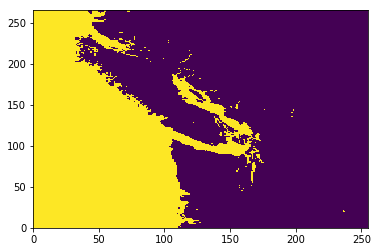

In [9]:
rpndata = xr.open_dataset('/data/dlatorne/MEOPAR/GEMLAM-netcdf/2014110206_007.nc')
TT = rpndata['TT'][0, 0, JST:JEN, IST:IEN]
mymask = TT > 282 - 273.15
plt.pcolormesh(mymask)
print (mymask.shape)

In [10]:
def calculate_stats(a, b, mymask, repeats):
    mask = np.repeat(mymask, repeats)
    bias = np.ma.array(b-a, mask=mask).mean()
    rmse = np.sqrt(np.ma.array((b - a)**2, mask=mask).mean())
    return bias, rmse

In [11]:
bias = np.empty((6, 10))
rmse = np.empty((6, 10))

In [37]:
values = {}
ntimes = 100
results = np.empty((ntimes, 6, 67575))
ops_lw = np.empty((ntimes, 67575))
fmask = np.array(mymask).flatten()

0 20171122 06 001
1 20170725 18 005
2 20180605 06 017
3 20170807 00 014
4 20171123 18 034
5 20180706 12 035
6 20180120 18 029
7 20181108 12 020
8 20171004 06 012
9 20180710 12 003
10 20180320 12 037
11 20180519 06 003
12 20171126 12 013
13 20181129 06 014
14 20171221 18 048
15 20190224 18 010
16 20181201 06 005
17 20170914 00 005
18 20181217 06 020
19 20180203 00 012
20 20180622 18 030
21 20180827 00 046
22 20190225 06 030
23 20180823 12 014
24 20180425 18 032
25 20181113 12 009
26 20171004 12 033
27 20170914 12 025
28 20180816 00 035
29 20180404 12 047
30 20190221 12 022
31 20171008 18 003
32 20171210 06 028
33 20180714 12 045
34 20170830 06 033
35 20171217 12 026
36 20180816 18 021
37 20170809 12 008
38 20180620 00 033
39 20180710 00 025
40 20180822 18 029
41 20181008 18 047
42 20170827 12 022
43 20181216 06 037
44 20181024 18 025
45 20180502 00 016
46 20170727 18 010
47 20190114 18 037
48 20171124 06 045
49 20181122 00 048
50 20180202 12 016
51 20180801 06 024
52 20180916 18 045
53 

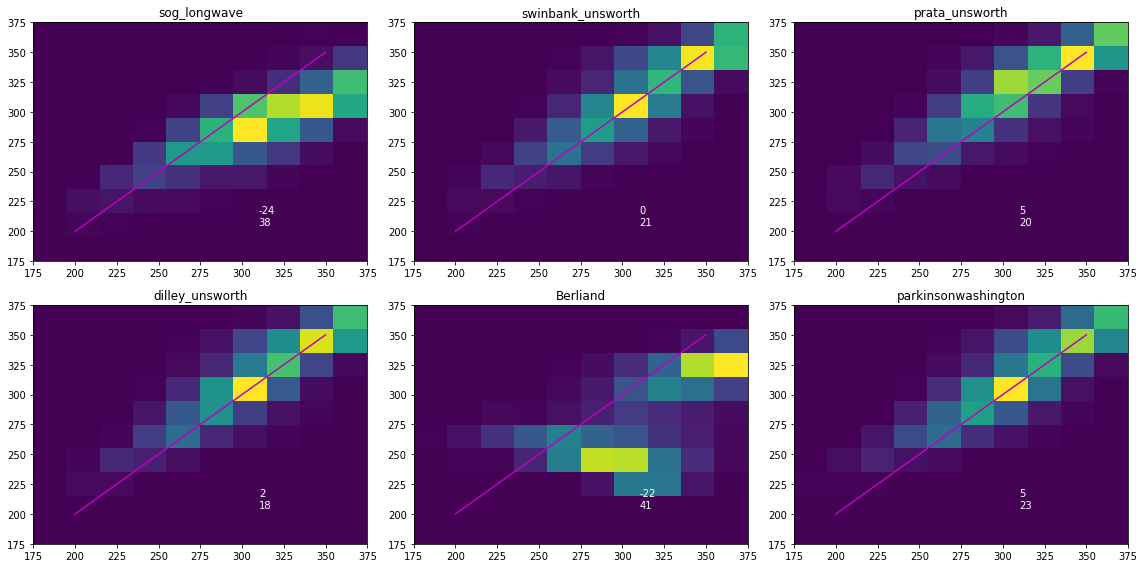

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
for times in range(ntimes):
    day = firstday.shift(days=random.randint(0, ndays))
    daystring = day.format('YYYYMMDD')
    forecaststring = forecast[random.randint(0, 3)]
    shour = random.randint(1, 48)
    hour = f'{shour:03}'
    phour = f'{shour-1:03}'
    print (times, daystring, forecaststring, hour)
    if shour != 1:
        dwl_ph, latitude = get_a_field(filenames[3], names[3], 'prevday.nc', phour, resultsdir, daystring, forecaststring)
    for k in range(5):
        values[names[k]], latitude = get_a_field(filenames[k], names[k], tmpfiles[k], hour, resultsdir, daystring, forecaststring)
        if names[k] == 'DLWRF_surface':
            if shour != 1:
                values[names[k]] = (values[names[k]] - dwl_ph)/3600.
            else:
                values[names[k]] = values[names[k]]/3600.
    r, xvw, ew = calculate_vp(values['PRMSL_meansealevel'], values['SPFH_2maboveground'])
    for k, model in enumerate(models):
        results[times, k, :] = np.array(model(latitude, ew, values['TCDC_surface']/100., values['TMP_2maboveground'], sigma)).flatten()
    ops_lw[times, :] = np.array(values['DLWRF_surface']).flatten()
for k, model in enumerate(models):  
    if k < 3:
        i, j = 0, k
    else:
        i, j = 1, k-3
    axs[i,j].hist2d((ops_lw*fmask).flatten(), (results[:, k, :]*fmask).flatten(),
                   range=[[175, 375], [175, 375]])
    axs[i,j].plot([200, 350], [200, 350], 'm-')
    axs[i,j].set_title(model.__name__)
    bias2, rmse2 = calculate_stats(ops_lw, results[:, k], fmask, ntimes)
    print (model.__name__, bias2, rmse2)
    axs[i,j].text(310, 215, str(bias2.astype(int)), color='w')
    axs[i,j].text(310, 205, str(rmse2.astype(int)), color='w')
fig.tight_layout()        

99
sog_longwave -24.560450864901625 38.093063009685565
swinbank_unsworth 0.6862157393375095 21.659559788357235
prata_unsworth 5.69488750207576 20.019822179932802
dilley_unsworth 2.27006449658886 18.207420616471005
Berliand -22.377915784782754 41.93076496918721
parkinsonwashington 5.56071803609556 23.345154360550232


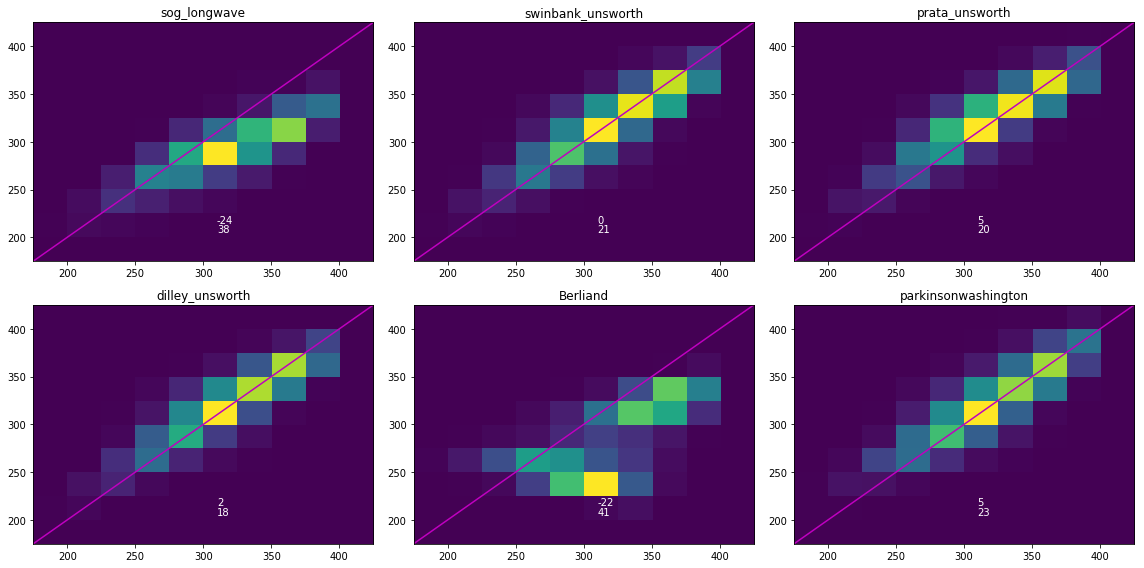

In [39]:
it = 2
print(times)
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
for k, model in enumerate(models):  
    if k < 3:
        i, j = 0, k
    else:
        i, j = 1, k-3
    axs[i,j].hist2d((ops_lw*fmask).flatten(), (results[:, k, :]*fmask).flatten(),
                   range=[[175, 425], [175, 425]])
    axs[i,j].plot([175, 425], [175, 425], 'm-')
    axs[i,j].set_title(model.__name__)
    bias[k, it], rmse[k, it] = calculate_stats(ops_lw, results[:, k], fmask, ntimes)
    print (model.__name__, bias[k, it], rmse[k, it])
    axs[i,j].text(310, 215, str(bias[k, it].astype(int)), color='w')
    axs[i,j].text(310, 205, str(rmse[k, it].astype(int)), color='w')
fig.tight_layout()        

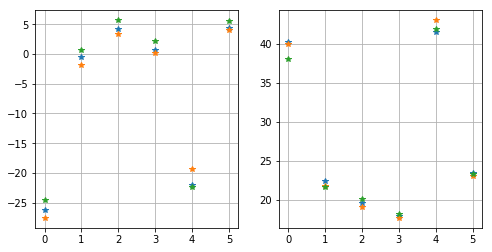

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(bias[:, 0:3], '*')
axs[1].plot(rmse[:, 0:3], '*')
for ax in axs:
    ax.grid();

In [43]:
print (bias[:, 0:3].mean(axis=1))
print (bias[:, 0:3].std(axis=1))

[-26.14273954  -0.53182244   4.43778572   1.08852595 -21.23909131
   4.66880178]
[1.23781304 1.01061778 0.94202406 0.85991789 1.39345827 0.64415862]


* SOG : bias -26.1 +- 1.2
* Swinbank/Unsworth : bias -0.5 +- 1.0
* Prata/Unsworth : bias 4.4 +- 0.9
* Dilley/Unsworth : bias 1.1 +- 0.8
* Berliand : bias -21.2 +- 1.4
* ParkinsonWashington : bias 4.7 +- 0.6

Clearly out: SOG and Berliand

Moderate but clearly not making the grade: Prata and Parkinson

Of Swinbank and Dilley, Swinbank is better but not clearly at this point

In [44]:
print (rmse[:, 0:3].mean(axis=1))
print (rmse[:, 0:3].std(axis=1))

[39.4666817  21.93121427 19.55890907 17.9045656  42.19395084 23.26059327]
[0.97475152 0.32384402 0.39228727 0.23312296 0.61932764 0.16806211]



    * SOG : rmse 39.5 +- 1.0
    * Swinbank/Unsworth : rmse 21.9 +- 0.3
    * Prata/Unsworth : rmse 19.6 +- 0.4
    * Dilley/Unsworth : rmse 17.9 +- 0.2
    * Berliand : rmse 42.2 +- 0.6
    * ParkinsonWashington : bias 23.3 +- 0.2

Clearly out: SOG and Berliand

Moderate but clearly not making the grade: Swinbank and Parkinson

Of Prata and Dilley, Dilley is clearly better


DILLEY!

In [13]:
# from sog
def sog_longwave(lat, vp, rpn_NT_on_ops, rpn_TT_on_ops, sigma):
    # cf  cloud fraction 
    # atemp_value  current air temperature [K]

    atemp_value = rpn_TT_on_ops
    cf = rpn_NT_on_ops
    
    r = 0.03
    Ce = 9.37e-6

    # Downward radiation from atmosphere
    # *** There are several different ways to calculate this
    lw_in = ((1 - r) * (1 + 0.170 * cf**2) * Ce * atemp_value**2 
         * sigma * atemp_value**4)

    return lw_in

In [14]:
def swinbank_unsworth(lat, vp, rpn_NT_on_ops, rpn_TT_on_ops, sigma):
    To = rpn_TT_on_ops
    Lclr = 5.31e-13*To**6   # Swinbank
    eclr = Lclr/(sigma * To**4)
    cf = rpn_NT_on_ops
    ewc = (1 - 0.84*cf)*eclr + 0.84*cf # Unsworth
    Lwc = ewc * sigma * To**4
    return Lwc

In [15]:
def prata_unsworth(lat, rpn_vp_on_ops, rpn_NT_on_ops, rpn_TT_on_ops, sigma):
    eo = rpn_vp_on_ops/1000.
    To = rpn_TT_on_ops
    w = 465*eo/To  
    eclr = 1 - (1 + w) * np.exp(-(1.2 + 3*w)**0.5)
    cf = rpn_NT_on_ops
    ewc = (1 - 0.84*cf)*eclr + 0.84*cf # Unsworth
    Lwc = ewc * sigma * To**4
    return Lwc

In [16]:
def dilley_unsworth(lat, rpn_vp_on_ops, rpn_NT_on_ops, rpn_TT_on_ops, sigma):
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR007394
# Dilley clear sky algorithm
    eo = rpn_vp_on_ops/1000.
    To = rpn_TT_on_ops
    w = 465*eo/To
    Lclr = 59.38 + 113.7*(To/273.16)**6 + 96.96*np.sqrt(w/2.5) # Dilley
    eclr = Lclr/(sigma * To**4)
# Unsworth
    cf = rpn_NT_on_ops
    ewc = (1 - 0.84*cf)*eclr + 0.84*cf
#
    Lwc = ewc * sigma * To**4
    return Lwc

In [19]:
#DATA budyko / 1.00, 0.98, 0.95, 0.92, 0.89, 0.86, 0.83, 0.80, 0.78, 0.75,   &
#      &          0.72, 0.69, 0.67, 0.64, 0.61, 0.58, 0.56, 0.53, 0.50 /
budyko = [1.00, 0.98, 0.95, 0.92, 0.89, 0.86, 0.83, 0.80, 0.78, 0.75,   
               0.72, 0.69, 0.67, 0.64, 0.61, 0.58, 0.56, 0.53, 0.50]
sbudyko = np.zeros_like(latitude)
# and the correction factor for taking into account  the effect of clouds 
for jj in range(latitude.shape[1]):
    for ji in range(latitude.shape[0]):
#         DO jj = 1, jpj
#            DO ji = 1 , jpi
#    zalat          = ( 90.e0 - ABS( gphit(ji,jj) ) ) /  5.e0
        zalat = (90 - np.abs(np.array(latitude[ji, jj]))) / 5
#               indxb          = 1 + INT( zalat )
        indxb = zalat.astype(int)
# correction factor to account for the effect of clouds
        sbudyko[ji,jj] = budyko[indxb]

In [20]:
def Berliand(rpn_lat, rpn_vp_on_ops, rpn_NT_on_ops, rpn_TT_on_ops, sigma):

#--------------------------------------!
#  long-wave radiation over the ocean  !  ( Berliand 1952 ; all latitudes )
#--------------------------------------!
#ztatm = sf(jp_tair)%fnow(ji,jj,1)
#ztatm3  = ztatm * ztatm * ztatm
    ztatm4 = rpn_TT_on_ops**4
    zcldeff = 1.0 - sbudyko * rpn_NT_on_ops**2
    ztaevbk = ztatm4 * zcldeff * ( 0.39 - 0.05 * np.sqrt(rpn_vp_on_ops) ) 
    zqlw = 0.97 * sigma * ( ztaevbk + 4. * ztatm4 ) / 4.
    return zqlw

In [21]:
def parkinsonwashington(lat, vp, cf, TT, sigma):
    Lw = sigma * TT**4 * (1 
                          - 0.261 * np.exp(-7.77e-4 * (273 - TT)**2)) * (1 + 0.275*cf) 
    return Lw